<a href="https://colab.research.google.com/github/Rohit1217/VAE/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [19]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((128,),(128,))])

# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=128,shuffle=False)

In [21]:
class Encoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,latent_dim):
    super(Encoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.latent_dim=latent_dim
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel+2)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv3=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv4=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv5=nn.Conv2d(out_channels,2,kernel)
    self.conv6=nn.Conv2d(out_channels,2,kernel)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.bn3=nn.BatchNorm2d(out_channels)
    self.bn4=nn.BatchNorm2d(out_channels)
    self.bn5=nn.BatchNorm2d(2)


  def forward(self,x):
    x=F.gelu(self.bn1(self.conv1(x)))
    x=F.gelu(self.bn2(self.conv2(x)))
    x=F.gelu(self.bn3(self.conv3(x)))
    x=F.gelu(self.bn4(self.conv4(x)))
    x=F.gelu(self.bn5(self.conv5(x)))
    mean,log_variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.latent_dim,self.latent_dim).to(get_device())
    z=mean+epsilon*log_variance
    return mean,log_variance,z

'''enc=Encoder(1,64,5,6)
x=enc(torch.ones(6,1,28,28))
x[0].shape,x[2].shape'''

'enc=Encoder(1,64,5,6)\nx=enc(torch.ones(6,1,28,28))\nx[0].shape,x[2].shape'

In [22]:
class Decoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,input_dim):
    super(Decoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.input_dim=input_dim
    self.conv1=nn.ConvTranspose2d(in_channels,out_channels,kernel )
    self.conv2=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv3=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv4=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv5=nn.ConvTranspose2d(out_channels,2,kernel+2)
    self.conv6=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.bn3=nn.BatchNorm2d(out_channels)
    self.bn4=nn.BatchNorm2d(out_channels)
    self.bn5=nn.BatchNorm2d(2)


  def forward(self,x):
    x=F.gelu(self.bn1(self.conv1(x)))
    x=F.gelu(self.bn2(self.conv2(x)))
    x=F.gelu(self.bn3(self.conv3(x)))
    x=F.gelu(self.bn4(self.conv4(x)))
    x=F.gelu(self.bn5(self.conv5(x)))
    mean,variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.input_dim,self.input_dim).to(get_device())
    return mean+epsilon*variance

'''enc=Decoder(1,64,5,28)
x=enc(torch.ones(2,1,6,6))
x.shape,x'''

'enc=Decoder(1,64,5,28)\nx=enc(torch.ones(2,1,6,6))\nx.shape,x'

In [23]:
class VAE(nn.Module):
  def __init__(self,input_dim,latent_dim,in_channels,out_channels,kernel):
    super(VAE,self).__init__()
    self.input_dim=input_dim
    self.latent_dim=latent_dim
    self.encoder=Encoder(in_channels,out_channels,kernel,latent_dim)
    self.decoder=Decoder(in_channels,out_channels,kernel,input_dim)
    self.e=1e-8

  def forward(self,x):
    z,mean,log_variance=self.encoder(x)
    b,w,h=z.shape
    z=z.view(b,1,w,h)
    x=x.view(b,self.input_dim,self.input_dim)
    x_re=self.decoder(z)
    return x_re,x,mean,log_variance

'''vae=VAE(28,6,1,64,5)
x=vae(torch.randn(6,1,28,28))
x[0].shape,x[1].shape,x[2].shape,x[3].shape,x'''

'vae=VAE(28,6,1,64,5)\nx=vae(torch.randn(6,1,28,28))\nx[0].shape,x[1].shape,x[2].shape,x[3].shape,x'

In [31]:
def Loss(x_re,x_or,mean,log_variance):
  re_loss=F.binary_cross_entropy_with_logits(x_re,x_or)
  b,c,c=mean.shape
  log_variance=log_variance.view(b,c*c)
  mean=mean.view(b,c*c)
  kl=torch.sum(-0.5*(1+log_variance-torch.exp(log_variance)-torch.pow(mean,2)),dim=1)
  kl=torch.mean(kl)
  return (re_loss+kl)
'''Loss(x[0],x[1],x[2],x[3])'''

'Loss(x[0],x[1],x[2],x[3])'

In [ ]:
model=VAE(28,6,1,64,5)
model=model.to(get_device())
epochs=50
optimizer=optim.Adam(model.parameters(),lr=0.0001)
for epoch in range(epochs):
  total_loss=0
  count=0
  for x,_ in trainloader:
    x=x.to(get_device())
    x_re,x,mean,log_variance=model(x)
    loss=Loss(x_re,x,mean,log_variance)

    total_loss+=loss.item()
    count+=1
    #print(total_loss)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    #for name, param in model.decoder.named_parameters():
    #  if param.grad is not None:
    #    pass
    #      #print(f'a')
      #print(x_re,x,mean,log_variance,loss)


  print(f'total_loss{total_loss},mse_loss{total_loss/count},epoch{epoch}')

total_loss792.460310280323,mse_loss1.689680832154207,epoch0
total_loss331.8506664633751,mse_loss0.707570717405917,epoch1
total_loss299.08503019809723,mse_loss0.6377079535140666,epoch2
total_loss279.17622715234756,mse_loss0.5952584800689713,epoch3
total_loss266.8673520088196,mse_loss0.5690135437288264,epoch4
total_loss254.9687301516533,mse_loss0.543643347871329,epoch5
total_loss246.9825857281685,mse_loss0.5266153213820224,epoch6
total_loss239.7787883579731,mse_loss0.5112554122771281,epoch7
total_loss240.9404255449772,mse_loss0.5137322506289492,epoch8
total_loss229.82168939709663,mse_loss0.4900249240876261,epoch9
total_loss225.63838201761246,mse_loss0.4811052921484274,epoch10
total_loss222.65713903307915,mse_loss0.47474869729867625,epoch11
total_loss228.17144256830215,mse_loss0.4865062741328404,epoch12
total_loss215.7156921029091,mse_loss0.45994817079511535,epoch13


torch.Size([28, 28])


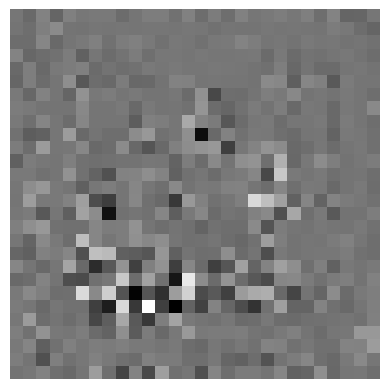

In [38]:
for x,_ in trainloader:
  y=x
  x=x.to(get_device())
  z=torch.randn(6,1,6,6)
  z=z.to('cuda:0')
  mean,log_variance,z=model.encoder(x)
  z=z.view(128,1,6,6)
  x=model.decoder(z)
  print(x[0].shape)
  x=x[5]
  x=x.view(28,28)
  #x=data[0].view(28,28)
  x=x.to('cpu')
  image_np = x.detach().numpy()
  break
# Display the image using matplotlib

plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()